# Learning-Based Compressive Subsampling


# Discrete Cosine Transform

In [16]:
import numpy as np
import torch
import torch_dct as dct

# x = torch.tensor(np.random.normal(size=(3, 200, 200)))
# X = dct.dct_2d(x)   # DCT-II done through the last dimension
# y = dct.idct_2d(X)  # scaled DCT-III done through the last dimension
# assert (torch.abs(x - y)).sum() < 1e-10  # x == y within numerical tolerance

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
from torch_dct import dct
import torch.optim
from torch.autograd import Variable
from torch import fft, ifft, irfft, rfft
#from models import *
#from utils.denoising_utils import *

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs", torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

torch.set_printoptions(precision=4)

num GPUs 1


In [3]:
num_of_training = 140
image_size = 128

# Root directory for dataset
data_root = "./celebACroppedData/"



data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to (-1, 1) range
                           ]))

# shuffle data
random.seed(7)
img_lib = np.arange(1, len(data_set), 1)
random.shuffle(img_lib)

# training data
train_set = torch.utils.data.Subset(data_set, img_lib[:num_of_training])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)

# validate specific images
val_set = torch.utils.data.Subset(data_set, img_lib[:num_of_training])
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

## Load target image

tensor(0.) tensor(1.)
torch.Size([1, 3, 128, 128])


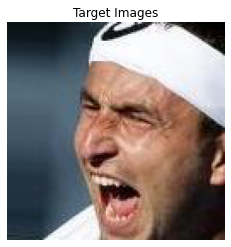

In [4]:
# dataloader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True, num_workers=2)

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Target Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].type(dtype)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

img_var = real_batch[0]
print(torch.min(img_var), torch.max(img_var))
print(img_var.shape)
img_np = var_to_np(img_var)
img_var = img_var.type(dtype)
output_depth = img_np.shape[0]

## Define forward model

In [5]:
X = img_var.reshape(-1, np.prod(img_var.shape) )
# X = img_var.view(-1, np.prod(img_var.shape) )
n = X.shape[1]
m = int(n/20)
A = torch.empty(n,m).normal_(0, 1).type(dtype)
A *= 1/np.sqrt(m)
print(m)

2457


In [6]:
def forwardm(img_var):
    X = img_var.reshape(-1 , np.prod(img_var.shape) )
    return torch.mm(X, A)
forwardm(img_var).shape

torch.Size([1, 2457])

In [7]:
# with a random mask
# mask = np_to_var(1.0*(np.random.randint(3, size=img_np_small.shape)<1)).type(dtype)
# def forwardm(img_var):
#     return img_var * mask

## DD reconstruction and helper functions

In [8]:
def get_net_input(num_channels,w=128,h=128):
    totalupsample = 2**len(num_channels)
    width = int(128/totalupsample)
    height = int(128/totalupsample)
    shape = [1,num_channels[0], width, height]
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    net_input.data *= 1./10
    return net_input

def get_random_img(num_channels,ni=None):
    if ni is None:
        ni = get_net_input(num_channels)
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    print("generated random image with", num_channels, " network has ", num_param(net) )
    return net(ni)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')    
    
def plot_img(img_ref): 
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure   
    ax1 = fig.add_subplot(231)
    ax1.imshow(img_ref,cmap='gray')
    #ax1.set_title('Original image')
    ax1.axis('off')
    
def init_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            #m.weight.data.uniform_()
            #torch.nn.init.xavier_uniform(m.weight)
            #nn.init.uniform_(m.weight)
            torch.nn.init.normal_(m.weight)

def snr(x_hat,x_true):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse= np.sum( np.square(x_hat-x_true) )
    #snr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    snr_ = mse / np.sum( np.square(x_true) )
    return snr_

In [9]:
def dd_recovery(measurement, img_var, num_channnels, num_iter=4000, apply_f=forwardm, ni=None):
    # net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    
    in_size = (16, 16)
    
    img_np = var_to_np(img_var)
    out_size = img_np.shape[1:]
    
    net = deepdecoder( in_size, out_size,
                output_depth,
                num_channels=num_channels,
                need_sigmoid=True,
                #need_tanh=True,
                last_noup=False,
               ).type(dtype)
    
    # net.apply(init_weights)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        net_input=ni,
                        reg_noise_std=0.0,
                        num_iter=num_iter,
                        #OPTIMIZER='SGD',
                        #LR = 0.01, #LR = 0.005,
                        OPTIMIZER='adam',
                        LR = 0.005, #LR = 0.005,
                        img_noisy_var=measurement.type(dtype),
                        net=net, 
                        apply_f = apply_f,
                        img_clean_var=img_var.type(dtype),
                        upsample_mode='free',
                        in_size = in_size,
                        )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var, mse_n, mse_t

## Example reconstruction

In [10]:
#num_channels = [256]*4
#num_channels = [512]*5
num_channels = [256]*5
measurement = forwardm(img_var).type(dtype)
out_img_var, mse_n, mse_t = dd_recovery(measurement, img_var, num_channels)

[(25, 25), (37, 37), (56, 56), (85, 85), (128, 128)]
input shape:  [1, 256, 16, 16]
init norm:  114.58131
orig img norm:  119.927155
optimize with adam 0.005
331008ion 03990    Train loss 0.000000  Actual loss 0.005285 Actual loss orig 0.005285 


In [11]:
print(measurement.shape, img_var.shape)

torch.Size([1, 2457]) torch.Size([1, 3, 128, 128])


0.13465108


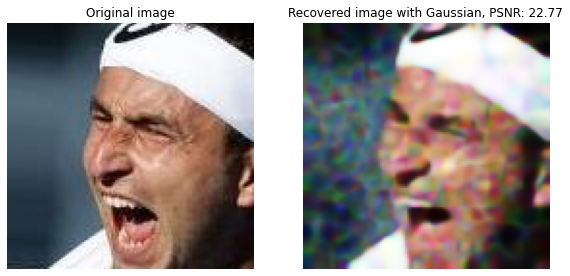

In [12]:
# orig_img = img_var.data.cpu().numpy()[0,0]
# rec_img = out_img_var.data.cpu().numpy()[0,0]
orig_img = img_var.data.cpu().numpy()[0]
rec_img = out_img_var.data.cpu().numpy()[0]

def show(plt, img):
#     plt.imshow(img, cmap='gray')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image with Gaussian, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

In [13]:
# define R_omega
img_size = img_var.shape[-1]
n = np.prod(img_var.shape)

c0 = np.zeros(n-m)
c1 = np.ones(m)
R_np = np.concatenate((c0, c1), axis=0)
random.shuffle(R_np)

R = np_to_var(R_np).type(dtype)
R = R.view(-1)
R.shape

torch.Size([49152])

In [17]:
def forward_cosine(img_var):
    img_dct = dct.dct_2d(img_var[0]).type(dtype)
    x = img_dct.reshape(np.prod(img_dct.shape) )

    Rx = R * x
    return Rx

forward_cosine(img_var).shape

torch.Size([49152])

In [18]:
num_channels = [256]*5
y = forward_cosine(img_var)
y

tensor([0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, 1.3651],
       device='cuda:0')

In [19]:
out_img_var, mse_n, mse_t = dd_recovery(y.data, img_var, num_channels, apply_f=forward_cosine)

[(25, 25), (37, 37), (56, 56), (85, 85), (128, 128)]
input shape:  [1, 256, 16, 16]
init norm:  114.14054
orig img norm:  119.927155
optimize with adam 0.005
331008ion 03990    Train loss 0.699785  Actual loss 0.135958 Actual loss orig 0.135958   


0.62371176


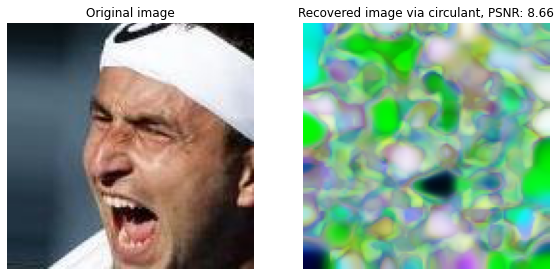

In [20]:
# orig_img = img_var.data.cpu().numpy()[0,0]
# rec_img = out_img_var.data.cpu().numpy()[0,0]
orig_img = img_var.data.cpu().numpy()[0]
rec_img = out_img_var.data.cpu().numpy()[0]

fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image via dct, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

In [21]:
def vanilla_cosine(img_var):
    img_dct = dct.dct_2d(img_var[0]).type(dtype)
    x = img_dct.reshape(np.prod(img_dct.shape))
    return x

acc = torch.zeros(n).type(dtype)
for i, (train_img_var, _) in enumerate(train_loader):
    acc += vanilla_cosine(train_img_var) ** 2
    
acc_np = np.array(acc.cpu()).reshape(-1) 

top_m_i = np.argpartition(acc_np, -m)[-m:] 
R_learned_np = np.zeros(n)
R_learned_np[top_m_i] = 1
print(np.count_nonzero(R_learned_np))

2457


In [22]:
R_learned = np_to_var(R_learned_np).type(dtype)
R_learned = R_learned.view(-1)
R_learned.shape

torch.Size([49152])

In [23]:
np.sort(acc_np[np.nonzero(acc_np * R_learned_np)])

array([2.8384816e+05, 2.8423362e+05, 2.8469075e+05, ..., 8.2219778e+10,
       1.1116873e+11, 1.8078899e+11], dtype=float32)

In [24]:
torch.sort(acc[top_m_i])

torch.return_types.sort(
values=tensor([2.8385e+05, 2.8423e+05, 2.8469e+05,  ..., 8.2220e+10, 1.1117e+11,
        1.8079e+11], device='cuda:0'),
indices=tensor([   0,    1,    2,  ..., 1671, 1766, 2456], device='cuda:0'))

In [25]:
def learned_forward_cosine(img_var):
    img_dct = dct.dct_2d(img_var[0]).type(dtype)
    x = img_dct.reshape(np.prod(img_dct.shape) )

    RCx_learned = R_learned * x
    return RCx_learned

In [26]:
num_channels = [256]*5
y = learned_forward_cosine(img_var)

print(torch.max(y**2), torch.min(y[torch.nonzero(y)]**2))

tensor(1.0232e+09, device='cuda:0') tensor(0.0011, device='cuda:0')


In [27]:
m

2457

In [28]:
torch.nonzero(y).shape

torch.Size([2457, 1])

In [29]:
out_img_var, mse_n, mse_t = dd_recovery(y.data, img_var, num_channels, apply_f=learned_forward_cosine)

[(25, 25), (37, 37), (56, 56), (85, 85), (128, 128)]
input shape:  [1, 256, 16, 16]
init norm:  114.784904
orig img norm:  119.927155
optimize with adam 0.005
331008ion 03990    Train loss 0.007220  Actual loss 0.002618 Actual loss orig 0.002618    


0.09468455


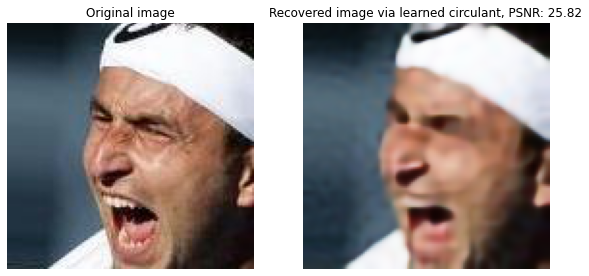

In [30]:
orig_img = img_var.data.cpu().numpy()[0]
rec_img = out_img_var.data.cpu().numpy()[0]

fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image via learned circulant, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

In [31]:
y_ax = np.array(vanilla_cosine(img_var).cpu())
x_ax = np.arange(1, 49153)

No handles with labels found to put in legend.


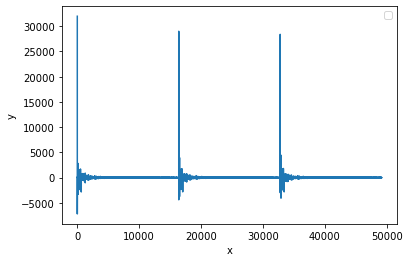

In [32]:
plt.plot(x_ax, y_ax)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()

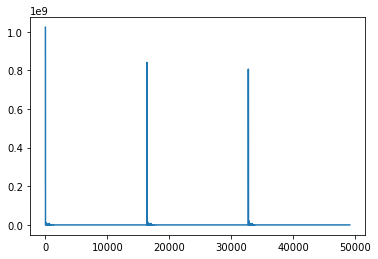

In [33]:
plt.plot(x_ax, y_ax**2)

In [34]:
y

tensor([31987.5293, -5620.2393, -7208.8398,  ...,    -0.0000,    -0.0000,
            0.0000], device='cuda:0')